<a href="https://colab.research.google.com/github/dcher95/universe7/blob/pytorch/pytorch/zero_to_mastery/03_pytorch_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. PyTorch Computer Vision

In [2]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}\ntorchvision version: {torchvision.__version__}")

PyTorch version: 2.3.0+cu121
torchvision version: 0.18.0+cu121


In [3]:
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 52.1 MB/s eta 0:00:00


## 1. Getting a dataset

In [4]:
# Setup training data
train_data = datasets.FashionMNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.FashionMNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

100%|██████████| 26421880/26421880 [00:02<00:00, 12812747.21it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 203670.30it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3800179.01it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5784162.07it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



Let's check out the first sample of the training data.

In [5]:
# See first training sample
image, label = train_data[0]
image, label

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
           0.2863, 0.0000, 0.0000, 0.0039, 

### 1.1 Input and output shapes of a computer vision model

We've got a big tensor of values (the image) leading to a single value for the target (the label).

Let's see the image shape.

In [6]:
# What's the shape of the image?
image.shape

torch.Size([1, 28, 28])

The shape of the image tensor is `[1, 28, 28]` or more specifically:

```
[color_channels=1, height=28, width=28]
```

Having `color_channels=1` means the image is grayscale.

![example input and output shapes of the fashionMNIST problem](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-computer-vision-input-and-output-shapes.png)
*Various problems will have various input and output shapes. But the premise remains: encode data into numbers, build a model to find patterns in those numbers, convert those patterns into something meaningful.*

If `color_channels=3`, the image comes in pixel values for red, green and blue (this is also known a the [RGB color model](https://en.wikipedia.org/wiki/RGB_color_model)).

The order of our current tensor is often referred to as `CHW` (Color Channels, Height, Width).

There's debate on whether images should be represented as `CHW` (color channels first) or `HWC` (color channels last).

> **Note:** You'll also see `NCHW` and `NHWC` formats where `N` stands for *number of images*. For example if you have a `batch_size=32`, your tensor shape may be `[32, 1, 28, 28]`. We'll cover batch sizes later.

PyTorch generally accepts `NCHW` (channels first) as the default for many operators.

However, PyTorch also explains that `NHWC` (channels last) performs better and is [considered best practice](https://pytorch.org/blog/tensor-memory-format-matters/#pytorch-best-practice).

For now, since our dataset and models are relatively small, this won't make too much of a difference.

But keep it in mind for when you're working on larger image datasets and using convolutional neural networks (we'll see these later).

Let's check out more shapes of our data.

In [ ]:
# How many samples are there?
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

So we've got 60,000 training samples and 10,000 testing samples.

What classes are there?

We can find these via the `.classes` attribute.

In [7]:
# See classes
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

### 1.2 Visualizing our data

Image shape: torch.Size([1, 28, 28])


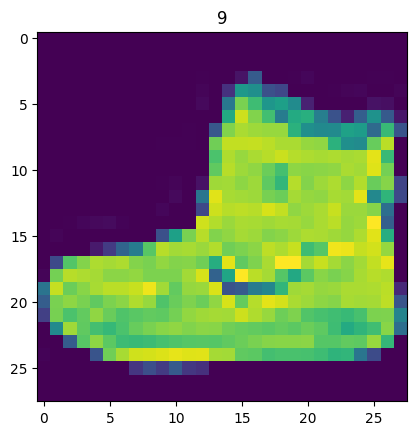

In [8]:
import matplotlib.pyplot as plt
image, label = train_data[0]
print(f"Image shape: {image.shape}")
plt.imshow(image.squeeze()) # image shape is [1, 28, 28] (colour channels, height, width)
plt.title(label);

We can turn the image into grayscale using the `cmap` parameter of `plt.imshow()`.

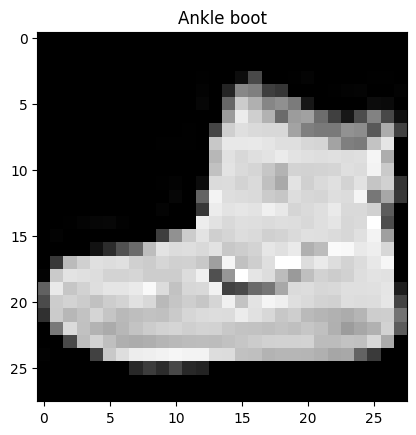

In [9]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label]);

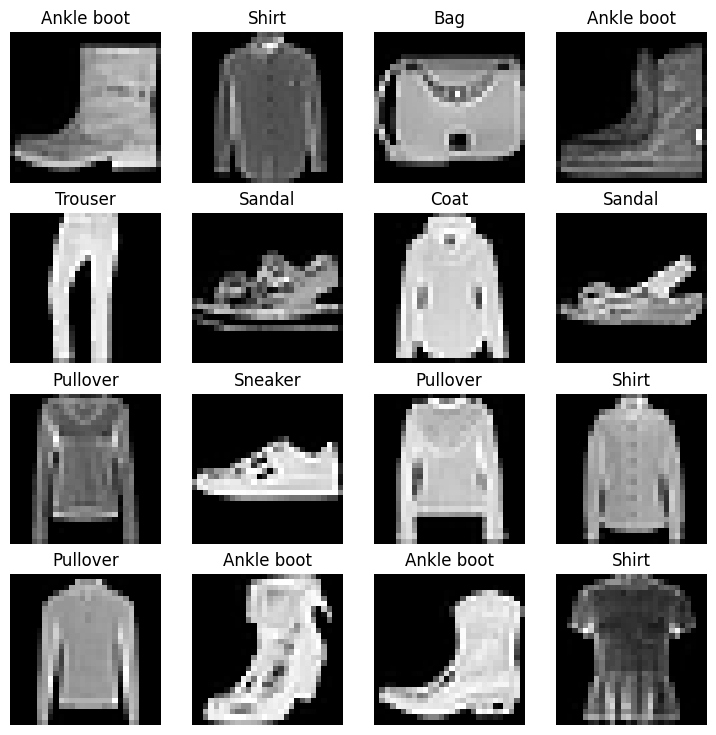

In [10]:
# Plot more images
torch.manual_seed(42)
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## 2. Prepare DataLoader


![an example of what a batched dataset looks like](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-batching-fashionmnist.png)
*Batching FashionMNIST with a batch size of 32 and shuffle turned on. A similar batching process will occur for other datasets but will differ depending on the batch size.*

In [11]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7969bb89dfc0>, <torch.utils.data.dataloader.DataLoader object at 0x7969bb89c2b0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [12]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

And we can see that the data remains unchanged by checking a single sample.

Image size: torch.Size([1, 28, 28])
Label: 6, label size: torch.Size([])


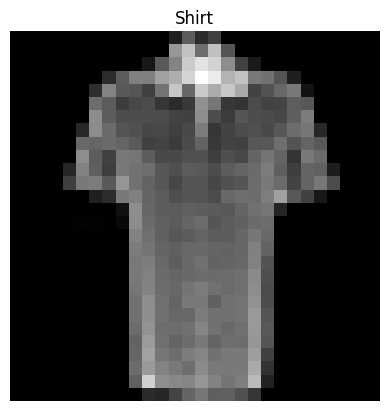

In [13]:
# Show a sample
torch.manual_seed(42)
random_idx = torch.randint(0, len(train_features_batch), size=[1]).item()
img, label = train_features_batch[random_idx], train_labels_batch[random_idx]
plt.imshow(img.squeeze(), cmap="gray")
plt.title(class_names[label])
plt.axis("Off");
print(f"Image size: {img.shape}")
print(f"Label: {label}, label size: {label.shape}")

## 3. Model 0: Build a baseline model


In [14]:
# Create a flatten layer
flatten_model = nn.Flatten() # all nn modules function as a model (can do a forward pass)

# Get a single sample
x = train_features_batch[0]

# Flatten the sample
output = flatten_model(x) # perform forward pass

# Print out what happened
print(f"Shape before flattening: {x.shape} -> [color_channels, height, width]")
print(f"Shape after flattening: {output.shape} -> [color_channels, height*width]")

# Try uncommenting below and see what happens
print(x)
print(output)

Shape before flattening: torch.Size([1, 28, 28]) -> [color_channels, height, width]
Shape after flattening: torch.Size([1, 784]) -> [color_channels, height*width]
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 

The `nn.Flatten()` layer took our shape from `[color_channels, height, width]` to `[color_channels, height*width]`.

Why do this?

Because we've now turned our pixel data from height and width dimensions into one long **feature vector**.

And `nn.Linear()` layers like their inputs to be in the form of feature vectors.

Let's create our first model using `nn.Flatten()` as the first layer.

In [15]:
from torch import nn
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # neural networks like their inputs in vector form
            nn.Linear(in_features=input_shape, out_features=hidden_units), # in_features = number of features in a data sample (784 pixels)
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

Wonderful!

We've got a baseline model class we can use, now let's instantiate a model.

We'll need to set the following parameters:
* `input_shape=784` - this is how many features you've got going in the model, in our case, it's one for every pixel in the target image (28 pixels high by 28 pixels wide = 784 features).
* `hidden_units=10` - number of units/neurons in the hidden layer(s), this number could be whatever you want but to keep the model small we'll start with `10`.
* `output_shape=len(class_names)` - since we're working with a multi-class classification problem, we need an output neuron per class in our dataset.

Let's create an instance of our model and send to the CPU for now (we'll run a small test for running `model_0` on CPU vs. a similar model on GPU soon).

In [16]:
torch.manual_seed(42)

# Need to setup model with input parameters
model_0 = FashionMNISTModelV0(input_shape=784, # one for every pixel (28x28)
    hidden_units=10, # how many units in the hiden layer
    output_shape=len(class_names) # one for every class
)
model_0.to("cpu") # keep model on CPU to begin with

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

### 3.1 Setup loss, optimizer and evaluation metrics

Since we're working on a classification problem, let's bring in our [`helper_functions.py` script](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py) and subsequently the `accuracy_fn()` we defined in [notebook 02](https://www.learnpytorch.io/02_pytorch_classification/).

> **Note:** Rather than importing and using our own accuracy function or evaluation metric(s), you could import various evaluation metrics from the [TorchMetrics package](https://torchmetrics.readthedocs.io/en/latest/).

In [17]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [19]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss() # this is also called "criterion"/"cost function" in some places
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### 3.2 Creating a function to time our experiments

Loss function and optimizer ready!

It's time to start training a model.

But how about we do a little experiment while we train.

I mean, let's make a timing function to measure the time it takes our model to train on CPU versus using a GPU.

We'll train this model on the CPU but the next one on the GPU and see what happens.

Our timing function will import the [`timeit.default_timer()` function](https://docs.python.org/3/library/timeit.html#timeit.default_timer) from the Python [`timeit` module](https://docs.python.org/3/library/timeit.html).

In [20]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format).
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### 3.3 Creating a training loop and training a model on batches of data

Beautiful!

Looks like we've got all of the pieces of the puzzle ready to go, a timer, a loss function, an optimizer, a model and most importantly, some data.

Let's now create a training loop and a testing loop to train and evaluate our model.

We'll be using the same steps as the previous notebook(s), though since our data is now in batch form, we'll add another loop to loop through our data batches.

Our data batches are contained within our `DataLoader`s, `train_dataloader` and `test_dataloader` for the training and test data splits respectively.

A batch is `BATCH_SIZE` samples of `X` (features) and `y` (labels), since we're using `BATCH_SIZE=32`, our batches have 32 samples of images and targets.

And since we're computing on batches of data, our loss and evaluation metrics will be calculated **per batch** rather than across the whole dataset.

This means we'll have to divide our loss and accuracy values by the number of batches in each dataset's respective dataloader.

Let's step through it:
1. Loop through epochs.
2. Loop through training batches, perform training steps, calculate the train loss *per batch*.
3. Loop through testing batches, perform testing steps, calculate the test loss *per batch*.
4. Print out what's happening.
5. Time it all (for fun).

A fair few steps but...

...if in doubt, code it out.

In [22]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# Set the seed and start the timer
torch.manual_seed(42)
train_time_start_on_cpu = timer()

# Set the number of epochs (we'll keep this small for faster training times)
epochs = 3

# Initialize the accuracy metric
train_accuracy = Accuracy(task = 'multiclass', num_classes=len(class_names))
test_accuracy = Accuracy(task = 'multiclass', num_classes=len(class_names))

# Create training and testing loop
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    ### Training
    train_loss = 0
    train_acc = 0  # Initialize training accuracy for the epoch

    # Add a loop to loop through training batches
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        # 1. Forward pass
        y_pred = model_0(X)

        # 2. Calculate loss (per batch)
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulatively add up the loss per epoch

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Update training accuracy
        train_acc += train_accuracy(y_pred.argmax(dim=1), y).item()

        # Print out how many samples have been seen
        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    # Divide total train loss by length of train dataloader (average loss per batch per epoch)
    train_loss /= len(train_dataloader)
    # Average accuracy over all batches
    train_acc /= len(train_dataloader)

    ### Testing
    # Setup variables for accumulatively adding up loss and accuracy
    test_loss, test_acc = 0, 0
    model_0.eval()
    with torch.inference_mode():
        for X, y in test_dataloader:
            # 1. Forward pass
            test_pred = model_0(X)

            # 2. Calculate loss (accumatively)
            test_loss += loss_fn(test_pred, y) # accumulatively add up the loss per epoch

            # 3. Calculate accuracy (preds need to be same as y_true)
            test_acc += test_accuracy(test_pred.argmax(dim=1), y).item()

        # Calculations on test metrics need to happen inside torch.inference_mode()
        # Divide total test loss by length of test dataloader (per batch)
        test_loss /= len(test_dataloader)

        # Divide total accuracy by length of test dataloader (per batch)
        test_acc /= len(test_dataloader)

    ## Print out what's happening
    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

    train_accuracy.reset()
    test_accuracy.reset()

# Calculate training time
train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu,
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.59039 | Test loss: 0.50954, Test acc: 0.82%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47633 | Test loss: 0.47989, Test acc: 0.83%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45503 | Test loss: 0.47664, Test acc: 0.83%

Train time on cpu: 34.798 seconds


Nice! Looks like our baseline model did fairly well.

It didn't take too long to train either, even just on the CPU, I wonder if it'll speed up on the GPU?

Let's write some code to evaluate our model.

## 4. Make predictions and get Model 0 results

Since we're going to be building a few models, it's a good idea to write some code to evaluate them all in similar ways.

Namely, let's create a function that takes in a trained model, a `DataLoader`, a loss function and an accuracy function.

The function will use the model to make predictions on the data in the `DataLoader` and then we can evaluate those predictions using the loss function and accuracy function.

In [23]:
# Import accuracy metric
from helper_functions import accuracy_fn

In [24]:
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)

            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y,
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)

        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 0 results on test dataset
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

Looking good!

We can use this dictionary to compare the baseline model results to other models later on.

## 5. Setup device agnostic-code (for using a GPU if there is one)
We've seen how long it takes to train ma PyTorch model on 60,000 samples on CPU.

> **Note:** Model training time is dependent on hardware used. Generally, more processors means faster training and smaller models on smaller datasets will often train faster than large models and large datasets.

Now let's setup some [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#best-practices) for our models and data to run on GPU if it's available.

If you're running this notebook on Google Colab, and you don't a GPU turned on yet, it's now time to turn one on via `Runtime -> Change runtime type -> Hardware accelerator -> GPU`. If you do this, your runtime will likely reset and you'll have to run all of the cells above by going `Runtime -> Run before`.

In [25]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Beautiful!

Let's build another model.

## 6. Model 1: Building a better model with non-linearity

We learned about [the power of non-linearity in notebook 02](https://www.learnpytorch.io/02_pytorch_classification/#6-the-missing-piece-non-linearity).

Seeing the data we've been working with, do you think it needs non-linear functions?

And remember, linear means straight and non-linear means non-straight.

Let's find out.

We'll do so by recreating a similar model to before, except this time we'll put non-linear functions (`nn.ReLU()`) in between each linear layer.

In [26]:
# Create a model with non-linear and linear layers
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(), # flatten inputs into single vector
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x: torch.Tensor):
        return self.layer_stack(x)

That looks good.

Now let's instantiate it with the same settings we used before.

We'll need `input_shape=784` (equal to the number of features of our image data), `hidden_units=10` (starting small and the same as our baseline model) and `output_shape=len(class_names)` (one output unit per class).

> **Note:** Notice how we kept most of the settings of our model the same except for one change: adding non-linear layers. This is a standard practice for running a series of machine learning experiments, change one thing and see what happens, then do it again, again, again.

In [27]:
torch.manual_seed(42)
model_1 = FashionMNISTModelV1(input_shape=784, # number of input features
    hidden_units=10,
    output_shape=len(class_names) # number of output classes desired
).to(device) # send model to GPU if it's available
next(model_1.parameters()).device # check model device

device(type='cuda', index=0)

### 6.1 Setup loss, optimizer and evaluation metrics

As usual, we'll setup a loss function, an optimizer and an evaluation metric (we could do multiple evaluation metrics but we'll stick with accuracy for now).

In [28]:
from helper_functions import accuracy_fn
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(),
                            lr=0.1)

### 6.2 Functionizing training and test loops

So far we've been writing train and test loops over and over.

Let's write them again but this time we'll put them in functions so they can be called again and again.

And because we're using device-agnostic code now, we'll be sure to call `.to(device)` on our feature (`X`) and target (`y`) tensors.

For the training loop we'll create a function called `train_step()` which takes in a model, a `DataLoader` a loss function and an optimizer.

The testing loop will be similar but it'll be called `test_step()` and it'll take in a model, a `DataLoader`, a loss function and an evaluation function.

> **Note:** Since these are functions, you can customize them in any way you like. What we're making here can be considered barebones training and testing functions for our specific classification use case.

In [29]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

Woohoo!

Now we've got some functions for training and testing our model, let's run them.

We'll do so inside another loop for each epoch.

That way for each epoch we're going a training and a testing step.

> **Note:** You can customize how often you do a testing step. Sometimes people do them every five epochs or 10 epochs or in our case, every epoch.

Let's also time things to see how long our code takes to run on the GPU.

In [30]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_on_gpu = timer()

epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(data_loader=test_dataloader,
        model=model_1,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

train_time_end_on_gpu = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_gpu,
                                            end=train_time_end_on_gpu,
                                            device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 1.09199 | Train accuracy: 61.34%
Test loss: 0.95636 | Test accuracy: 65.00%

Epoch: 1
---------
Train loss: 0.78101 | Train accuracy: 71.93%
Test loss: 0.72227 | Test accuracy: 73.91%

Epoch: 2
---------
Train loss: 0.67027 | Train accuracy: 75.94%
Test loss: 0.68500 | Test accuracy: 75.02%

Train time on cuda: 33.591 seconds


Excellent!

Our model trained but the training time took longer?

> **Note:** The training time on CUDA vs CPU will depend largely on the quality of the CPU/GPU you're using. Read on for a more explained answer.

> **Question:** "I used a a GPU but my model didn't train faster, why might that be?"
>
> **Answer:** Well, one reason could be because your dataset and model are both so small (like the dataset and model we're working with) the benefits of using a GPU are outweighed by the time it actually takes to transfer the data there.
>
> There's a small bottleneck between copying data from the CPU memory (default) to the GPU memory.
>
> So for smaller models and datasets, the CPU might actually be the optimal place to compute on.
>
> But for larger datasets and models, the speed of computing the GPU can offer usually far outweighs the cost of getting the data there.
>
> However, this is largely dependant on the hardware you're using. With practice, you will get used to where the best place to train your models is.

Let's evaluate our trained `model_1` using our `eval_model()` function and see how it went.

In [31]:
torch.manual_seed(42)

# Note: This will error due to `eval_model()` not using device agnostic code
model_1_results = eval_model(model=model_1,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn)
model_1_results

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

Oh no!

It looks like our `eval_model()` function errors out with:

> `RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument mat1 in method wrapper_addmm)`

It's because we've setup our data and model to use device-agnostic code but not our evaluation function.

How about we fix that by passing a target `device` parameter to our `eval_model()` function?

Then we'll try calculating the results again.

In [32]:
# Move values to device
torch.manual_seed(42)
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    """Evaluates a given model on a given dataset.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.
        device (str, optional): Target device to compute on. Defaults to device.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to the target device
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        # Scale loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}

# Calculate model 1 results with device-agnostic code
model_1_results = eval_model(model=model_1, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn,
    device=device
)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6850008964538574,
 'model_acc': 75.01996805111821}

In [33]:
# Check baseline results
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.47663888335227966,
 'model_acc': 83.42651757188499}

Woah, in this case, it looks like adding non-linearities to our model made it perform worse than the baseline.

That's a thing to note in machine learning, sometimes the thing you thought should work doesn't.

And then the thing you thought might not work does.

It's part science, part art.

From the looks of things, it seems like our model is **overfitting** on the training data.

Overfitting means our model is learning the training data well but those patterns aren't generalizing to the testing data.

Two of the main to fix overfitting include:
1. Using a smaller or different model (some models fit certain kinds of data better than others).
2. Using a larger dataset (the more data, the more chance a model has to learn generalizable patterns).

There are more, but I'm going to leave that as a challenge for you to explore.

Try searching online, "ways to prevent overfitting in machine learning" and see what comes up.

In the meantime, let's take a look at number 1: using a different model.

## 7. Model 2: Building a Convolutional Neural Network (CNN)

Alright, time to step things up a notch.

It's time to create a [Convolutional Neural Network](https://en.wikipedia.org/wiki/Convolutional_neural_network) (CNN or ConvNet).

CNN's are known for their capabilities to find patterns in visual data.

And since we're dealing with visual data, let's see if using a CNN model can improve upon our baseline.

The CNN model we're going to be using is known as TinyVGG from the [CNN Explainer](https://poloclub.github.io/cnn-explainer/) website.

It follows the typical structure of a convolutional neural network:

`Input layer -> [Convolutional layer -> activation layer -> pooling layer] -> Output layer`

Where the contents of `[Convolutional layer -> activation layer -> pooling layer]` can be upscaled and repeated multiple times, depending on requirements.

### What model should I use?

> **Question:** Wait, you say CNN's are good for images, are there any other model types I should be aware of?

Good question.

This table is a good general guide for which model to use (though there are exceptions).

| **Problem type** | **Model to use (generally)** | **Code example** |
| ----- | ----- | ----- |
| Structured data (Excel spreadsheets, row and column data) | Gradient boosted models, Random Forests, XGBoost | [`sklearn.ensemble`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble), [XGBoost library](https://xgboost.readthedocs.io/en/stable/) |
| Unstructured data (images, audio, language) | Convolutional Neural Networks, Transformers | [`torchvision.models`](https://pytorch.org/vision/stable/models.html), [HuggingFace Transformers](https://huggingface.co/docs/transformers/index) |

> **Note:** The table above is only for reference, the model you end up using will be highly dependant on the problem you're working on and the constraints you have (amount of data, latency requirements).

Enough talking about models, let's now build a CNN that replicates the model on the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

![TinyVGG architecture, as setup by CNN explainer website](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-cnn-explainer-model.png)

To do so, we'll leverage the [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) and [`nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) layers from `torch.nn`.


In [34]:
# Create a convolutional neural network
class FashionMNISTModelV2(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(x.shape)
        x = self.block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x

torch.manual_seed(42)
model_2 = FashionMNISTModelV2(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names)).to(device)
model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

Nice!

Our biggest model yet!

What we've done is a common practice in machine learning.

Find a model architecture somewhere and replicate it with code.

### 7.1 Stepping through `nn.Conv2d()`

We could start using our model above and see what happens but let's first step through the two new layers we've added:
* [`nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), also known as a convolutional layer.
* [`nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html), also known as a max pooling layer.

> **Question:** What does the "2d" in `nn.Conv2d()` stand for?
>
> The 2d is for 2-dimensional data. As in, our images have two dimensions: height and width. Yes, there's color channel dimension but each of the color channel dimensions have two dimensions too: height and width.
>
> For other dimensional data (such as 1D for text or 3D for 3D objects) there's also `nn.Conv1d()` and `nn.Conv3d()`.

To test the layers out, let's create some toy data just like the data used on CNN Explainer.

In [35]:
torch.manual_seed(42)

# Create sample batch of random numbers with same size as image batch
images = torch.randn(size=(32, 3, 64, 64)) # [batch_size, color_channels, height, width]
test_image = images[0] # get a single image for testing
print(f"Image batch shape: {images.shape} -> [batch_size, color_channels, height, width]")
print(f"Single image shape: {test_image.shape} -> [color_channels, height, width]")
print(f"Single image pixel values:\n{test_image}")

Image batch shape: torch.Size([32, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Single image shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Single image pixel values:
tensor([[[ 1.9269,  1.4873,  0.9007,  ...,  1.8446, -1.1845,  1.3835],
         [ 1.4451,  0.8564,  2.2181,  ...,  0.3399,  0.7200,  0.4114],
         [ 1.9312,  1.0119, -1.4364,  ..., -0.5558,  0.7043,  0.7099],
         ...,
         [-0.5610, -0.4830,  0.4770,  ..., -0.2713, -0.9537, -0.6737],
         [ 0.3076, -0.1277,  0.0366,  ..., -2.0060,  0.2824, -0.8111],
         [-1.5486,  0.0485, -0.7712,  ..., -0.1403,  0.9416, -0.0118]],

        [[-0.5197,  1.8524,  1.8365,  ...,  0.8935, -1.5114, -0.8515],
         [ 2.0818,  1.0677, -1.4277,  ...,  1.6612, -2.6223, -0.4319],
         [-0.1010, -0.4388, -1.9775,  ...,  0.2106,  0.2536, -0.7318],
         ...,
         [ 0.2779,  0.7342, -0.3736,  ..., -0.4601,  0.1815,  0.1850],
         [ 0.7205, -0.2833,  0.0937,  ..., -0.1002, -2.3609,

Let's create an example `nn.Conv2d()` with various parameters:
* `in_channels` (int) - Number of channels in the input image.
* `out_channels` (int) - Number of channels produced by the convolution.
* `kernel_size` (int or tuple) - Size of the convolving kernel/filter.
* `stride` (int or tuple, optional) - How big of a step the convolving kernel takes at a time. Default: 1.
* `padding` (int, tuple, str) - Padding added to all four sides of input. Default: 0.

![example of going through the different parameters of a Conv2d layer](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv2d-layer.gif)

*Example of what happens when you change the hyperparameters of a `nn.Conv2d()` layer.*

In [36]:
torch.manual_seed(42)

# Create a convolutional layer with same dimensions as TinyVGG
# (try changing any of the parameters and see what happens)
conv_layer = nn.Conv2d(in_channels=3,
                       out_channels=10,
                       kernel_size=3,
                       stride=1,
                       padding=0) # also try using "valid" or "same" here

# Pass the data through the convolutional layer
conv_layer(test_image) # Note: If running PyTorch <1.11.0, this will error because of shape issues (nn.Conv.2d() expects a 4d tensor as input)

tensor([[[ 1.5396,  0.0516,  0.6454,  ..., -0.3673,  0.8711,  0.4256],
         [ 0.3662,  1.0114, -0.5997,  ...,  0.8983,  0.2809, -0.2741],
         [ 1.2664, -1.4054,  0.3727,  ..., -0.3409,  1.2191, -0.0463],
         ...,
         [-0.1541,  0.5132, -0.3624,  ..., -0.2360, -0.4609, -0.0035],
         [ 0.2981, -0.2432,  1.5012,  ..., -0.6289, -0.7283, -0.5767],
         [-0.0386, -0.0781, -0.0388,  ...,  0.2842,  0.4228, -0.1802]],

        [[-0.2840, -0.0319, -0.4455,  ..., -0.7956,  1.5599, -1.2449],
         [ 0.2753, -0.1262, -0.6541,  ..., -0.2211,  0.1999, -0.8856],
         [-0.5404, -1.5489,  0.0249,  ..., -0.5932, -1.0913, -0.3849],
         ...,
         [ 0.3870, -0.4064, -0.8236,  ...,  0.1734, -0.4330, -0.4951],
         [-0.1984, -0.6386,  1.0263,  ..., -0.9401, -0.0585, -0.7833],
         [-0.6306, -0.2052, -0.3694,  ..., -1.3248,  0.2456, -0.7134]],

        [[ 0.4414,  0.5100,  0.4846,  ..., -0.8484,  0.2638,  1.1258],
         [ 0.8117,  0.3191, -0.0157,  ...,  1

If we try to pass a single image in, we get a shape mismatch error:

> `RuntimeError: Expected 4-dimensional input for 4-dimensional weight [10, 3, 3, 3], but got 3-dimensional input of size [3, 64, 64] instead`
>
> **Note:** If you're running PyTorch 1.11.0+, this error won't occur.

This is because our `nn.Conv2d()` layer expects a 4-dimensional tensor as input with size `(N, C, H, W)` or `[batch_size, color_channels, height, width]`.

Right now our single image `test_image` only has a shape of `[color_channels, height, width]` or `[3, 64, 64]`.

We can fix this for a single image using `test_image.unsqueeze(dim=0)` to add an extra dimension for `N`.

In [37]:
# Add extra dimension to test image
test_image.unsqueeze(dim=0).shape

torch.Size([1, 3, 64, 64])

In [38]:
# Pass test image with extra dimension through conv_layer
conv_layer(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 62, 62])

Hmm, notice what happens to our shape (the same shape as the first layer of TinyVGG on [CNN Explainer](https://poloclub.github.io/cnn-explainer/)), we get different channel sizes as well as different pixel sizes.

What if we changed the values of `conv_layer`?

In [39]:
torch.manual_seed(42)
# Create a new conv_layer with different values (try setting these to whatever you like)
conv_layer_2 = nn.Conv2d(in_channels=3, # same number of color channels as our input image
                         out_channels=10,
                         kernel_size=(5, 5), # kernel is usually a square so a tuple also works
                         stride=2,
                         padding=0)

# Pass single image through new conv_layer_2 (this calls nn.Conv2d()'s forward() method on the input)
conv_layer_2(test_image.unsqueeze(dim=0)).shape

torch.Size([1, 10, 30, 30])

Woah, we get another shape change.

Now our image is of shape `[1, 10, 30, 30]` (it will be different if you use different values) or `[batch_size=1, color_channels=10, height=30, width=30]`.

What's going on here?

Behind the scenes, our `nn.Conv2d()` is compressing the information stored in the image.

It does this by performing operations on the input (our test image) against its internal parameters.

The goal of this is similar to all of the other neural networks we've been building.

Data goes in and the layers try to update their internal parameters (patterns) to lower the loss function thanks to some help of the optimizer.

The only difference is *how* the different layers calculate their parameter updates or in PyTorch terms, the operation present in the layer `forward()` method.

If we check out our `conv_layer_2.state_dict()` we'll find a similar weight and bias setup as we've seen before.

In [40]:
# Check out the conv_layer_2 internal parameters
print(conv_layer_2.state_dict())

OrderedDict([('weight', tensor([[[[ 0.0883,  0.0958, -0.0271,  0.1061, -0.0253],
          [ 0.0233, -0.0562,  0.0678,  0.1018, -0.0847],
          [ 0.1004,  0.0216,  0.0853,  0.0156,  0.0557],
          [-0.0163,  0.0890,  0.0171, -0.0539,  0.0294],
          [-0.0532, -0.0135, -0.0469,  0.0766, -0.0911]],

         [[-0.0532, -0.0326, -0.0694,  0.0109, -0.1140],
          [ 0.1043, -0.0981,  0.0891,  0.0192, -0.0375],
          [ 0.0714,  0.0180,  0.0933,  0.0126, -0.0364],
          [ 0.0310, -0.0313,  0.0486,  0.1031,  0.0667],
          [-0.0505,  0.0667,  0.0207,  0.0586, -0.0704]],

         [[-0.1143, -0.0446, -0.0886,  0.0947,  0.0333],
          [ 0.0478,  0.0365, -0.0020,  0.0904, -0.0820],
          [ 0.0073, -0.0788,  0.0356, -0.0398,  0.0354],
          [-0.0241,  0.0958, -0.0684, -0.0689, -0.0689],
          [ 0.1039,  0.0385,  0.1111, -0.0953, -0.1145]]],


        [[[-0.0903, -0.0777,  0.0468,  0.0413,  0.0959],
          [-0.0596, -0.0787,  0.0613, -0.0467,  0.0701],

Look at that! A bunch of random numbers for a weight and bias tensor.

The shapes of these are manipulated by the inputs we passed to `nn.Conv2d()` when we set it up.

Let's check them out.

In [41]:
# Get shapes of weight and bias tensors within conv_layer_2
print(f"conv_layer_2 weight shape: \n{conv_layer_2.weight.shape} -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]")
print(f"\nconv_layer_2 bias shape: \n{conv_layer_2.bias.shape} -> [out_channels=10]")

conv_layer_2 weight shape: 
torch.Size([10, 3, 5, 5]) -> [out_channels=10, in_channels=3, kernel_size=5, kernel_size=5]

conv_layer_2 bias shape: 
torch.Size([10]) -> [out_channels=10]


> **Question:** What should we set the parameters of our `nn.Conv2d()` layers?
>
> That's a good one. But similar to many other things in machine learning, the values of these aren't set in stone (and recall, because these values are ones we can set ourselves, they're referred to as "**hyperparameters**").
>
> The best way to find out is to try out different values and see how they effect your model's performance.
>
> Or even better, find a working example on a problem similar to yours (like we've done with TinyVGG) and copy it.

We're working with a different of layer here to what we've seen before.

But the premise remains the same: start with random numbers and update them to better represent the data.

### 7.2 Stepping through `nn.MaxPool2d()`
Now let's check out what happens when we move data through `nn.MaxPool2d()`.

In [42]:
# Print out original image shape without and with unsqueezed dimension
print(f"Test image original shape: {test_image.shape}")
print(f"Test image with unsqueezed dimension: {test_image.unsqueeze(dim=0).shape}")

# Create a sample nn.MaxPoo2d() layer
max_pool_layer = nn.MaxPool2d(kernel_size=2)

# Pass data through just the conv_layer
test_image_through_conv = conv_layer(test_image.unsqueeze(dim=0))
print(f"Shape after going through conv_layer(): {test_image_through_conv.shape}")

# Pass data through the max pool layer
test_image_through_conv_and_max_pool = max_pool_layer(test_image_through_conv)
print(f"Shape after going through conv_layer() and max_pool_layer(): {test_image_through_conv_and_max_pool.shape}")

Test image original shape: torch.Size([3, 64, 64])
Test image with unsqueezed dimension: torch.Size([1, 3, 64, 64])
Shape after going through conv_layer(): torch.Size([1, 10, 62, 62])
Shape after going through conv_layer() and max_pool_layer(): torch.Size([1, 10, 31, 31])


Notice the change in the shapes of what's happening in and out of a `nn.MaxPool2d()` layer.

The `kernel_size` of the `nn.MaxPool2d()` layer will effects the size of the output shape.

In our case, the shape halves from a `62x62` image to `31x31` image.

Let's see this work with a smaller tensor.

In [43]:
torch.manual_seed(42)
# Create a random tensor with a similiar number of dimensions to our images
random_tensor = torch.randn(size=(1, 1, 2, 2))
print(f"Random tensor:\n{random_tensor}")
print(f"Random tensor shape: {random_tensor.shape}")

# Create a max pool layer
max_pool_layer = nn.MaxPool2d(kernel_size=2) # see what happens when you change the kernel_size value

# Pass the random tensor through the max pool layer
max_pool_tensor = max_pool_layer(random_tensor)
print(f"\nMax pool tensor:\n{max_pool_tensor} <- this is the maximum value from random_tensor")
print(f"Max pool tensor shape: {max_pool_tensor.shape}")

Random tensor:
tensor([[[[0.3367, 0.1288],
          [0.2345, 0.2303]]]])
Random tensor shape: torch.Size([1, 1, 2, 2])

Max pool tensor:
tensor([[[[0.3367]]]]) <- this is the maximum value from random_tensor
Max pool tensor shape: torch.Size([1, 1, 1, 1])


Notice the final two dimensions between `random_tensor` and `max_pool_tensor`, they go from `[2, 2]` to `[1, 1]`.

In essence, they get halved.

And the change would be different for different values of `kernel_size` for `nn.MaxPool2d()`.

Also notice the value leftover in `max_pool_tensor` is the **maximum** value from `random_tensor`.

What's happening here?

This is another important piece of the puzzle of neural networks.

Essentially, **every layer in a neural network is trying to compress data from higher dimensional space to lower dimensional space**.

In other words, take a lot of numbers (raw data) and learn patterns in those numbers, patterns that are predictive whilst also being *smaller* in size than the original values.

From an artificial intelligence perspective, you could consider the whole goal of a neural network to *compress* information.

![each layer of a neural network compresses the original input data into a smaller representation that is (hopefully) capable of making predictions on future input data](https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/03-conv-net-as-compression.png)

This means, that from the point of view of a neural network, intelligence is compression.

This is the idea of the use of a `nn.MaxPool2d()` layer: take the maximum value from a portion of a tensor and disregard the rest.

In essence, lowering the dimensionality of a tensor whilst still retaining a (hopefully) significant portion of the information.

It is the same story for a `nn.Conv2d()` layer.

Except instead of just taking the maximum, the `nn.Conv2d()` performs a convolutional operation on the data (see this in action on the [CNN Explainer webpage](https://poloclub.github.io/cnn-explainer/)).

> **Exercise:** What do you think the [`nn.AvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AvgPool2d.html) layer does? Try making a random tensor like we did above and passing it through. Check the input and output shapes as well as the input and output values.

> **Extra-curriculum:** Lookup "most common convolutional neural networks", what architectures do you find? Are any of them contained within the [`torchvision.models`](https://pytorch.org/vision/stable/models.html) library? What do you think you could do with these?

### 7.3 Setup a loss function and optimizer for `model_2`

We've stepped through the layers in our first CNN enough.

But remember, if something still isn't clear, try starting small.

Pick a single layer of a model, pass some data through it and see what happens.

Now it's time to move forward and get to training!

Let's setup a loss function and an optimizer.

We'll use the functions as before, `nn.CrossEntropyLoss()` as the loss function (since we're working with multi-class classification data).

And `torch.optim.SGD()` as the optimizer to optimize `model_2.parameters()` with a learning rate of `0.1`.

In [44]:
# Setup loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(),
                             lr=0.1)

### 7.4 Training and testing `model_2` using our training and test functions

Loss and optimizer ready!

Time to train and test.

We'll use our `train_step()` and `test_step()` functions we created before.

We'll also measure the time to compare it to our other models.

In [45]:
torch.manual_seed(42)

# Measure time
from timeit import default_timer as timer
train_time_start_model_2 = timer()

# Train and test model
epochs = 3
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model_2,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

train_time_end_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2,
                                           end=train_time_end_model_2,
                                           device=device)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.59411 | Train accuracy: 78.44%
Test loss: 0.39882 | Test accuracy: 85.64%

Epoch: 1
---------
Train loss: 0.36318 | Train accuracy: 86.92%
Test loss: 0.35391 | Test accuracy: 87.00%

Epoch: 2
---------
Train loss: 0.32683 | Train accuracy: 88.09%
Test loss: 0.32168 | Test accuracy: 88.05%

Train time on cuda: 40.856 seconds


Woah! Looks like the convolutional and max pooling layers helped improve performance a little.

Let's evaluate `model_2`'s results with our `eval_model()` function.

In [46]:
# Get model_2 results
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3216770887374878,
 'model_acc': 88.0491214057508}

## 8. Compare model results and training time

We've trained three different models.

1. `model_0` - our baseline model with two `nn.Linear()` layers.
2. `model_1` - the same setup as our baseline model except with `nn.ReLU()` layers in between the `nn.Linear()` layers.
3. `model_2` - our first CNN model that mimics the TinyVGG architecture on the CNN Explainer website.

This is a regular practice in machine learning.

Building multiple models and performing multiple training experiments to see which performs best.

Let's combine our model results dictionaries into a DataFrame and find out.

In [47]:
import pandas as pd
compare_results = pd.DataFrame([model_0_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.321677,88.049121


Nice!

We can add the training time values too.

In [48]:
# Add training times to results comparison
compare_results["training_time"] = [total_train_time_model_0,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.476639,83.426518,34.797574
1,FashionMNISTModelV1,0.685001,75.019968,33.590899
2,FashionMNISTModelV2,0.321677,88.049121,40.856270


It looks like our CNN (`FashionMNISTModelV2`) model performed the best (lowest loss, highest accuracy) but had the longest training time.

And our baseline model (`FashionMNISTModelV0`) performed better than `model_1` (`FashionMNISTModelV1`).

### Performance-speed tradeoff

Something to be aware of in machine learning is the **performance-speed** tradeoff.

Generally, you get better performance out of a larger, more complex model (like we did with `model_2`).

However, this performance increase often comes at a sacrifice of training speed and inference speed.

> **Note:** The training times you get will be very dependant on the hardware you use.
>
> Generally, the more CPU cores you have, the faster your models will train on CPU. And similar for GPUs.
>
> Newer hardware (in terms of age) will also often train models faster due to incorporating technology advances.

How about we get visual?

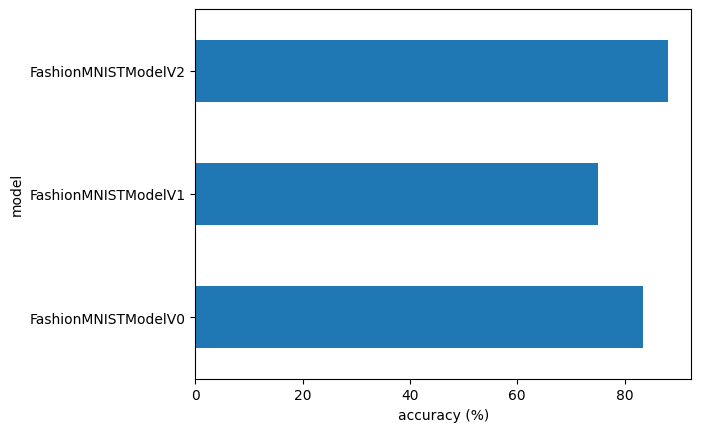

In [49]:
# Visualize our model results
compare_results.set_index("model_name")["model_acc"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model");

## 9. Make and evaluate random predictions with best model

Alright, we've compared our models to each other, let's further evaluate our best performing model, `model_2`.

To do so, let's create a function `make_predictions()` where we can pass the model and some data for it to predict on.

In [50]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [51]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 5 (Sandal)


In [52]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[9.4430e-08, 4.1540e-09, 9.2977e-09, 5.5166e-08, 3.2873e-09, 9.9991e-01,
         1.8863e-07, 2.6049e-06, 1.2858e-05, 7.2739e-05],
        [1.5703e-02, 7.9366e-01, 3.2605e-04, 5.7471e-02, 8.1578e-02, 1.9378e-05,
         5.1092e-02, 2.3239e-05, 8.6814e-05, 4.3061e-05]])

And now we can use our `make_predictions()` function to predict on `test_samples`.

In [53]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_2,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[9.4430e-08, 4.1540e-09, 9.2977e-09, 5.5166e-08, 3.2873e-09, 9.9991e-01,
         1.8863e-07, 2.6049e-06, 1.2858e-05, 7.2739e-05],
        [1.5703e-02, 7.9366e-01, 3.2605e-04, 5.7471e-02, 8.1578e-02, 1.9378e-05,
         5.1092e-02, 2.3239e-05, 8.6814e-05, 4.3061e-05]])

Excellent!

And now we can go from prediction probabilities to prediction labels by taking the `torch.argmax()` of the output of the `torch.softmax()` activation function.

In [54]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([5, 1, 7, 4, 3, 0, 4, 7, 1])

In [55]:
# Are our predictions in the same form as our test labels?
test_labels, pred_classes

([5, 1, 7, 4, 3, 0, 4, 7, 1], tensor([5, 1, 7, 4, 3, 0, 4, 7, 1]))

Now our predicted classes are in the same format as our test labels, we can compare.

Since we're dealing with image data, let's stay true to the data explorer's motto.

"Visualize, visualize, visualize!"

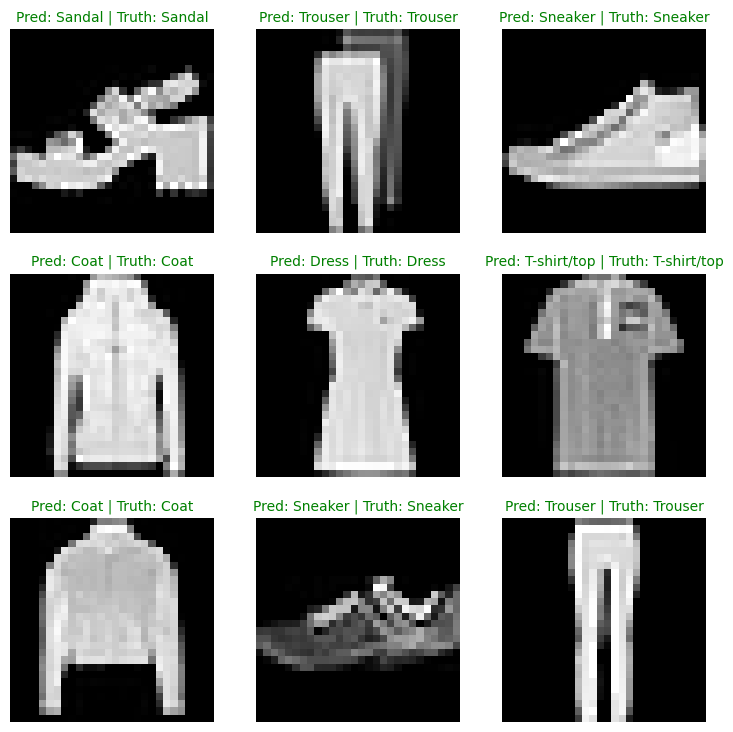

In [56]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

Well, well, well, doesn't that look good!

Not bad for a couple dozen lines of PyTorch code!

## 10. Making a confusion matrix for further prediction evaluation

There are many [different evaluation metrics](https://www.learnpytorch.io/02_pytorch_classification/#9-more-classification-evaluation-metrics) we can use for classification problems.

One of the most visual is a [confusion matrix](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/).

A confusion matrix shows you where your classification model got confused between predicitons and true labels.

To make a confusion matrix, we'll go through three steps:
1. Make predictions with our trained model, `model_2` (a confusion matrix compares predictions to true labels).
2. Make a confusion matrix using [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html?highlight=confusion#confusionmatrix).
3. Plot the confusion matrix using [`mlxtend.plotting.plot_confusion_matrix()`](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/).

Let's start by making predictions with our trained model.

In [57]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_2.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_2(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

Wonderful!

Now we've got predictions, let's go through steps 2 & 3:
2. Make a confusion matrix using [`torchmetrics.ConfusionMatrix`](https://torchmetrics.readthedocs.io/en/latest/references/modules.html?highlight=confusion#confusionmatrix).
3. Plot the confusion matrix using [`mlxtend.plotting.plot_confusion_matrix()`](http://rasbt.github.io/mlxtend/user_guide/plotting/plot_confusion_matrix/).

First we'll need to make sure we've got `torchmetrics` and `mlxtend` installed (these two libraries will help us make and visual a confusion matrix).

> **Note:** If you're using Google Colab, the default version of `mlxtend` installed is 0.14.0 (as of March 2022), however, for the parameters of the `plot_confusion_matrix()` function we'd like use, we need 0.19.0 or higher.

In [58]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

mlxtend version: 0.22.0


To plot the confusion matrix, we need to make sure we've got and [`mlxtend`](http://rasbt.github.io/mlxtend/) version of 0.19.0 or higher.

In [59]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.22.0


`torchmetrics` and `mlxtend` installed, let's make a confusion matrix!

First we'll create a `torchmetrics.ConfusionMatrix` instance telling it how many classes we're dealing with by setting `num_classes=len(class_names)`.

Then we'll create a confusion matrix (in tensor format) by passing our instance our model's predictions (`preds=y_pred_tensor`) and targets (`target=test_data.targets`).

Finally we can plot our confision matrix using the `plot_confusion_matrix()` function from `mlxtend.plotting`.

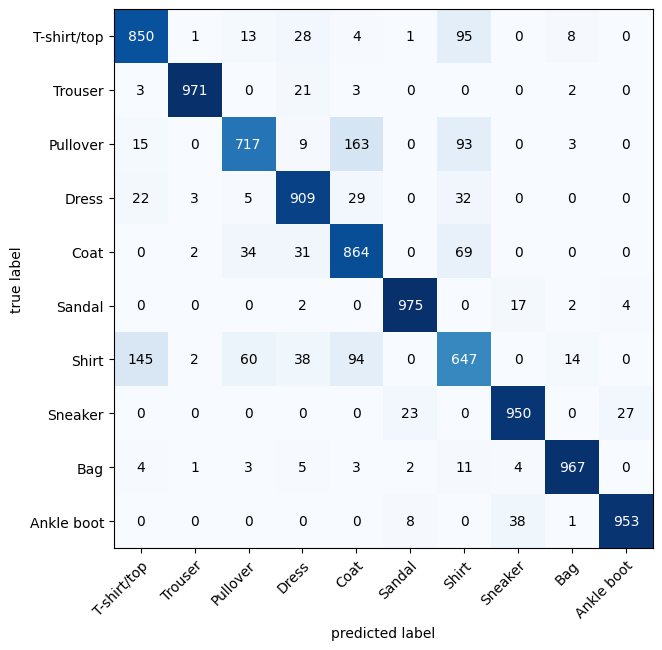

In [60]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

Woah! Doesn't that look good?

We can see our model does fairly well since most of the dark squares are down the diagonal from top left to bottom right (and ideal model will have only values in these squares and 0 everywhere else).

The model gets most "confused" on classes that are similar, for example predicting "Pullover" for images that are actually labelled "Shirt".

And the same for predicting "Shirt" for classes that are actually labelled "T-shirt/top".

This kind of information is often more helpful than a single accuracy metric because it tells use *where* a model is getting things wrong.

It also hints at *why* the model may be getting certain things wrong.

It's understandable the model sometimes predicts "Shirt" for images labelled "T-shirt/top".

We can use this kind of information to further inspect our models and data to see how it could be improved.

> **Exercise:** Use the trained `model_2` to make predictions on the test FashionMNIST dataset. Then plot some predictions where the model was wrong alongside what the label of the image should've been. After visualing these predictions do you think it's more of a modelling error or a data error? As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

## 11. Save and load best performing model

Let's finish this section off by saving and loading in our best performing model.

Recall from [notebook 01](https://www.learnpytorch.io/01_pytorch_workflow/#5-saving-and-loading-a-pytorch-model) we can save and load a PyTorch model using a combination of:
* `torch.save` - a function to save a whole PyTorch model or a model's `state_dict()`.
* `torch.load` - a function to load in a saved PyTorch object.
* `torch.nn.Module.load_state_dict()` - a function to load a saved `state_dict()` into an existing model instance.

You can see more of these three in the [PyTorch saving and loading models documentation](https://pytorch.org/tutorials/beginner/saving_loading_models.html).

For now, let's save our `model_2`'s `state_dict()` then load it back in and evaluate it to make sure the save and load went correctly.

In [61]:
from pathlib import Path

# Create models directory (if it doesn't already exist), see: https://docs.python.org/3/library/pathlib.html#pathlib.Path.mkdir
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, # create parent directories if needed
                 exist_ok=True # if models directory already exists, don't error
)

# Create model save path
MODEL_NAME = "03_pytorch_computer_vision_model_2.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_2.state_dict(), # only saving the state_dict() only saves the learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/03_pytorch_computer_vision_model_2.pth


Now we've got a saved model `state_dict()` we can load it back in using a combination of `load_state_dict()` and `torch.load()`.

Since we're using `load_state_dict()`, we'll need to create a new instance of `FashionMNISTModelV2()` with the same input parameters as our saved model `state_dict()`.

In [62]:
# Create a new instance of FashionMNISTModelV2 (the same class as our saved state_dict())
# Note: loading model will error if the shapes here aren't the same as the saved version
loaded_model_2 = FashionMNISTModelV2(input_shape=1,
                                    hidden_units=10, # try changing this to 128 and seeing what happens
                                    output_shape=10)

# Load in the saved state_dict()
loaded_model_2.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

# Send model to GPU
loaded_model_2 = loaded_model_2.to(device)

And now we've got a loaded model we can evaluate it with `eval_model()` to make sure its parameters work similarly to `model_2` prior to saving.

In [63]:
# Evaluate loaded model
torch.manual_seed(42)

loaded_model_2_results = eval_model(
    model=loaded_model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn
)

loaded_model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3216770887374878,
 'model_acc': 88.0491214057508}

Do these results look the same as `model_2_results`?

In [64]:
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3216770887374878,
 'model_acc': 88.0491214057508}

We can find out if two tensors are close to each other using `torch.isclose()` and passing in a tolerance level of closeness via the parameters `atol` (absolute tolerance) and `rtol` (relative tolerance).

If our model's results are close, the output of `torch.isclose()` should be true.

In [65]:
# Check to see if results are close to each other (if they are very far away, there may be an error)
torch.isclose(torch.tensor(model_2_results["model_loss"]),
              torch.tensor(loaded_model_2_results["model_loss"]),
              atol=1e-08, # absolute tolerance
              rtol=0.0001) # relative tolerance

tensor(True)

## Exercises

All of the exercises are focused on practicing the code in the sections above.

You should be able to complete them by referencing each section or by following the resource(s) linked.

All exercises should be completed using [device-agnostic code](https://pytorch.org/docs/stable/notes/cuda.html#device-agnostic-code).

**Resources:**
* [Exercise template notebook for 03](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/exercises/03_pytorch_computer_vision_exercises.ipynb)
* [Example solutions notebook for 03](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/03_pytorch_computer_vision_exercise_solutions.ipynb) (try the exercises *before* looking at this)

1. What are 3 areas in industry where computer vision is currently being used?
2. Search "what is overfitting in machine learning" and write down a sentence about what you find.
3. Search "ways to prevent overfitting in machine learning", write down 3 of the things you find and a sentence about each. **Note:** there are lots of these, so don't worry too much about all of them, just pick 3 and start with those.
4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).
    * Upload your own example image using the "upload" button and see what happens in each layer of a CNN as your image passes through it.
5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.
6. Visualize at least 5 different samples of the MNIST training dataset.
7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.
8. Recreate `model_2` used in this notebook (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.
9. Train the model you built in exercise 8. on CPU and GPU and see how long it takes on each.
10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.
11. Plot a confusion matrix comparing your model's predictions to the truth labels.
12. Create a random tensor of shape `[1, 3, 64, 64]` and pass it through a `nn.Conv2d()` layer with various hyperparameter settings (these can be any settings you choose), what do you notice if the `kernel_size` parameter goes up and down?
13. Use a model similar to the trained `model_2` from this notebook to make predictions on the test [`torchvision.datasets.FashionMNIST`](https://pytorch.org/vision/main/generated/torchvision.datasets.FashionMNIST.html) dataset.
    * Then plot some predictions where the model was wrong alongside what the label of the image should've been.
    * After visualing these predictions do you think it's more of a modelling error or a data error?
    * As in, could the model do better or are the labels of the data too close to each other (e.g. a "Shirt" label is too close to "T-shirt/top")?

## Extra-curriculum
* **Watch:** [MIT's Introduction to Deep Computer Vision](https://www.youtube.com/watch?v=iaSUYvmCekI&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3) lecture. This will give you a great intuition behind convolutional neural networks.
* Spend 10-minutes clicking thorugh the different options of the [PyTorch vision library](https://pytorch.org/vision/stable/index.html), what different modules are available?
* Lookup "most common convolutional neural networks", what architectures do you find? Are any of them contained within the [`torchvision.models`](https://pytorch.org/vision/stable/models.html) library? What do you think you could do with these?
* For a large number of pretrained PyTorch computer vision models as well as many different extensions to PyTorch's computer vision functionalities check out the [PyTorch Image Models library `timm`](https://github.com/rwightman/pytorch-image-models/) (Torch Image Models) by Ross Wightman.